In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests_cache
import yfinance as yf
import torch
import torch.nn as nn

%matplotlib inline
sns.set_theme()
device = torch.device("mps")


session = requests_cache.CachedSession("sentiment-model-3.cache")
print(device)

mps


## Data Preprocessing

In [2]:
sp500_df = yf.download(
    pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist(),
    period="10y",
    interval="1d",
    # session=session
)
sp500_df = sp500_df["Close"][["AAPL"]].fillna(0)
sp500_df.index = pd.to_datetime(sp500_df.index)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [3]:
sp500_df.head()

,AAPL
Date,
2013-11-29,19.859644
2013-12-02,19.686787
2013-12-03,20.225714
2013-12-04,20.178572
2013-12-05,20.282143


In [4]:
import pickle as pkl

with open("../data/post-firm-sentiment.pkl", "rb") as f:
    sentiment_df = pkl.load(f)
    sentiment_df.set_index("created", inplace=True)
    sentiment_df.index = sentiment_df.index.values.astype("datetime64[D]")
    sentiment_df.index.name = "created"

In [5]:
sentiment_df = sentiment_df[["selftext", "sentiment_score", "is_AAPL"]]
sentiment_df = sentiment_df[(sentiment_df["is_AAPL"] == True)].drop(["is_AAPL"], axis=1)

In [6]:
sentiment_df

,selftext,sentiment_score
created,,
2021-02-08,The next big thing. AAPL is the perfect target...,0.7639
2021-02-09,Just wondering where everyone is at with regar...,0.8999
2021-02-09,"I don’t know if I have a huge imagination, but...",-0.8527
2021-02-11,"Still crunching the numbers, but it appears Me...",0.9823
2021-02-12,It also didn't give him the option to buy AMC ...,0.8814
...,...,...
2021-11-23,I have a LT position on some AAPL since severa...,-0.5050
2021-11-27,"Hi everyone,\n\nI'm a college student. I am ha...",0.7650
2021-12-16,Say you buy AAPL a day before a June 5 ex-divi...,-0.2406


In [ ]:
# plt.figure(figsize=(10, 7))
# sentiment_df.drop(columns=["created", "selftext", "sentiment_score"]).sum(axis=0).sort_values(ascending=False).head(25).plot(kind="bar")
# plt.title("Top 25 most mentioned firms")
# plt.xlabel("Firm")
# plt.ylabel("Number of mentions")

In [ ]:
# plt.figure(figsize=(12, 7))
# sentiment_df["sentiment_score"].plot(kind="hist", bins=20)
# plt.title("Distribution of Sentiment Scores")
# plt.xlabel("Sentiment Score")
# plt.ylabel("Frequency")

In [7]:
sp500 = sp500_df.values

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# sp500 = scaler.fit_transform(sp500)

Axis 0 is temporal.

Axis 1 is individual companies.

In [8]:
sp500_df.index.values

array(['2013-11-29T00:00:00.000000000', '2013-12-02T00:00:00.000000000',
       '2013-12-03T00:00:00.000000000', ...,
       '2023-11-24T00:00:00.000000000', '2023-11-27T00:00:00.000000000',
       '2023-11-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
def split_data(raw_data_df: pd.DataFrame,
               train_size: float = 0.8,
               lookback_period: int = 30,
               lookforward_period: int = 30):
    """
    Takes a 2-array of data with axis 0 being temporal and axis 1 being companies and splits it into train and test sets.
    
    The first train_size percent of each timeseries is used for training and the rest is used for testing. Cross-validation folds
    are created using the lookback_period parameter in a sliding window paradigm. The target of each fold is the next value in the
    timeseries."""

    raw_data = raw_data_df.values
    dates = raw_data_df.index.values
    tickers = raw_data_df.columns.values

    train_size = int(raw_data.shape[0] * train_size)
    train_data = raw_data[:train_size, :]
    test_data = raw_data[train_size:, :]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]

    X_train = []
    X_train_dates = []
    y_train = []
    y_train_dates = []
    train_tickers = []
    X_test = []
    X_test_dates = []
    y_test = []
    y_test_dates = []
    test_tickers = []

    for i in range(lookback_period, train_data.shape[0] - lookforward_period + 1):
        X_train.append(train_data[i-lookback_period:i, :])
        X_train_dates.append(np.tile(train_dates[i-lookback_period:i, np.newaxis], (1, train_data.shape[1])))
        y_train.append(train_data[i:i+lookforward_period, :])
        y_train_dates.append(np.tile(train_dates[i:i+lookforward_period, np.newaxis], (1, train_data.shape[1])))
        train_tickers.append(tickers)

    for i in range(lookback_period, test_data.shape[0] - lookforward_period + 1):
        X_test.append(test_data[i-lookback_period:i, :])
        X_test_dates.append(np.tile(test_dates[i-lookback_period:i, np.newaxis], (1, test_data.shape[1])))
        y_test.append(test_data[i:i+lookforward_period, :])
        y_test_dates.append(np.tile(test_dates[i:i+lookforward_period, np.newaxis], (1, test_data.shape[1])))
        test_tickers.append(tickers)

    
    return (
        np.array(X_train).transpose(2, 0, 1).reshape(-1, lookback_period, 1),
        np.array(X_train_dates).transpose(2, 0, 1).reshape(-1, lookback_period, 1),
        np.array(y_train).transpose(2, 0, 1).reshape(-1, lookforward_period),
        np.array(y_train_dates).transpose(2, 0, 1).reshape(-1, lookforward_period),
        np.array(train_tickers)[:, np.newaxis, :].transpose(2, 0, 1).reshape(-1),
        np.array(X_test).transpose(2, 0, 1).reshape(-1, lookback_period, 1),
        np.array(X_test_dates).transpose(2, 0, 1).reshape(-1, lookback_period, 1),
        np.array(y_test).transpose(2, 0, 1).reshape(-1, lookforward_period),
        np.array(y_test_dates).transpose(2, 0, 1).reshape(-1, lookforward_period),
        np.array(test_tickers)[:, np.newaxis, :].transpose(2, 0, 1).reshape(-1),
    )

train_size = 0.80
lookback_period = 30
lookforward_period = 15
(X_train, X_train_dates, y_train, y_train_dates,
train_tickers, X_test, X_test_dates, y_test,
y_test_dates, test_tickers) = split_data(sp500_df,
                                              train_size=train_size,
                                              lookback_period=lookback_period,
                                              lookforward_period=lookforward_period)

print(f"X_train shape: {X_train.shape}")
print(f"X_train_dates shape: {X_train_dates.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train_dates shape: {y_train_dates.shape}")
print(f"train_tickers shape: {train_tickers.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_test_dates shape: {X_test_dates.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test_dates shape: {y_test_dates.shape}")
print(f"test_tickers shape: {test_tickers.shape}")

X_train shape: (1968, 30, 1)
X_train_dates shape: (1968, 30, 1)
y_train shape: (1968, 15)
y_train_dates shape: (1968, 15)
train_tickers shape: (1968,)
X_test shape: (460, 30, 1)
X_test_dates shape: (460, 30, 1)
y_test shape: (460, 15)
y_test_dates shape: (460, 15)
test_tickers shape: (460,)


In [ ]:
# remove a sample if its row (axis 1) contains a 0.0
train_mask = np.all(X_train != 0.0, axis=(1, 2))
test_mask = np.all(X_test != 0.0, axis=(1, 2))


X_train = X_train[train_mask, :, :]
X_train_dates = X_train_dates[train_mask, :, :]
y_train = y_train[train_mask, :]
y_train_dates = y_train_dates[train_mask, :]
train_tickers = train_tickers[train_mask]
X_test = X_test[test_mask, :, :]
X_test_dates = X_test_dates[test_mask, :, :]
y_test = y_test[test_mask, :]
y_test_dates = y_test_dates[test_mask, :]
test_tickers = test_tickers[test_mask]

Now:

X_train, X_test shape: (Number of windows, window size)

y_train, y_test shape: (Next value for each window)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_train_dates shape: {X_train_dates.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train_dates shape: {y_train_dates.shape}")
print(f"train_tickers shape: {train_tickers.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_test_dates shape: {X_test_dates.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test_dates shape: {y_test_dates.shape}")
print(f"test_tickers shape: {test_tickers.shape}")

In [ ]:
sentiment_df

In [ ]:
from tqdm import tqdm, trange

X_train_sentiment = np.zeros(X_train.shape[0])
X_test_sentiment = np.zeros(X_test.shape[0])

first_date = sentiment_df.index.min()
last_date = sentiment_df.index.max()

for i in trange(X_train.shape[0]):
    if X_train_dates[i, -1, 0] < first_date or X_train_dates[i, 0, 0] > last_date:
        X_train_sentiment[i] = 0.0
    else:
        X_train_sentiment[i] = sentiment_df.loc[sentiment_df.index.isin(X_train_dates[i, :, 0])]["sentiment_score"].values.mean()

for i in trange(X_test.shape[0]):
    if X_test_dates[i, -1, 0] < first_date or X_test_dates[i, 0, 0] > last_date:
        X_test_sentiment[i] = 0.0
    else:
        X_test_sentiment[i] = sentiment_df.loc[sentiment_df.index.isin(X_test_dates[i, :, 0])]["sentiment_score"].values.mean()

In [ ]:
# with open("../data/sentiment-scores-split.pkl", "wb") as f:
#     pkl.dump((X_train_sentiment, X_test_sentiment), f)

In [ ]:
# with open("../data/sentiment-scores-split.pkl", "rb") as f:
#     X_train_sentiment, X_test_sentiment = pkl.load(f)

In [ ]:
# Reshape and tile the sentiment scores to match the shape of the stock data
# This way we can concat them together and feed them to the model

X_train_sentiment = X_train_sentiment.reshape(-1, 1)
X_test_sentiment = X_test_sentiment.reshape(-1, 1)

print(f"X_train_sentiment shape: {X_train_sentiment.shape}")
print(f"X_test_sentiment shape: {X_test_sentiment.shape}")

In [ ]:
SUBSAMPLE_DATA = False
SUBSAMPLE_PERCENT = 0.1

if SUBSAMPLE_DATA:
    # Select a random subsample of the data
    subsample_train = np.random.choice(X_train.shape[0], int(X_train.shape[0] * SUBSAMPLE_PERCENT))
    subsample_test = np.random.choice(X_test.shape[0], int(X_test.shape[0] * SUBSAMPLE_PERCENT))

    X_train = X_train[subsample_train, :, :]
    y_train = y_train[subsample_train, :]
    X_test = X_test[subsample_test, :, :]
    y_test = y_test[subsample_test, :]

# convert train/test arrays to torch.Tensor
X_train = torch.from_numpy(X_train).float().to(device)
X_train_sentiment = torch.from_numpy(X_train_sentiment).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
X_test_sentiment = torch.from_numpy(X_test_sentiment).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

print(f"Type of X_train: {type(X_train)}")
print(f"Type of X_train_sentiment: {type(X_train_sentiment)}")
print(f"Type of y_train: {type(y_train)}")
print(f"Type of X_test: {type(X_test)}")
print(f"Type of X_test_sentiment: {type(X_test_sentiment)}")
print(f"Type of y_test: {type(y_test)}")

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_train_sentiment: {X_train_sentiment.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_test_sentiment: {X_test_sentiment.shape}")
print(f"Shape of y_test: {y_test.shape}")

## Model Training

In [245]:
input_size = 1 # num channels in input
num_layers = 4 # num of hidden layers
hidden_size = 128 # num of hidden nodes in each layer
output_size = lookforward_period # timesteps to predict

In [246]:
class LSTMModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.sentiment_fc = nn.Linear(1, hidden_size)
        self.combine_linear = nn.Linear(hidden_size * 2, 256)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    
    def forward(self, time_series: torch.Tensor, sentiment: torch.Tensor):
        h0 = torch.zeros(self.num_layers, time_series.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, time_series.size(0), self.hidden_size).to(device)

        lstm_out, _ = self.lstm(time_series, (h0, c0))
        sentiment_out = self.sentiment_fc(sentiment)
        combined = torch.cat((lstm_out[:, -1, :], sentiment_out), dim=1)
        out = self.combine_linear(combined)
        out = torch.relu(out)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)

        return out

In [247]:
from torch.utils.data import TensorDataset, DataLoader

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

train_data = TensorDataset(X_train, X_train_sentiment, y_train)
test_data = TensorDataset(X_test, X_test_sentiment, y_test)

# now that input windows are no longer grouped by company, we can shuffle the data
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

LSTMModel(
  (lstm): LSTM(1, 128, num_layers=4, batch_first=True)
  (sentiment_fc): Linear(in_features=1, out_features=128, bias=True)
  (combine_linear): Linear(in_features=256, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=15, bias=True)
)


In [249]:
from tqdm.notebook import tqdm, trange

num_epochs = 100
train_hist = []
test_hist = []

progress_bar = trange(num_epochs, desc="Epochs", postfix={"train_loss": 0.0, "test_loss": 0.0})
train_bar = tqdm(total=len(train_loader), desc="Training", leave=True)
test_bar = tqdm(total=len(test_loader), desc="Testing", leave=True)

for epoch in progress_bar:
    epoch_loss = 0.0

    # reset the progress bars
    train_bar.reset()
    test_bar.reset()

    # training loop
    model.train()
    for batch_X, sentiment_X, batch_y in train_loader:
        # tick the progress bar
        train_bar.update()

        # forward pass
        batch_X, sentiment_X, batch_y = batch_X.to(device), sentiment_X.to(device), batch_y.to(device)
        y_pred = model(batch_X, sentiment_X)
        loss = loss_fn(y_pred, batch_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_bar.refresh()
    train_hist.append(epoch_loss / len(train_loader))

    # testing loop
    model.eval()
    with torch.no_grad():
        epoch_loss = 0.0

        for batch_X, sentiment_X, batch_y in test_loader:
            # tick the progress bar
            test_bar.update()

            batch_X, sentiment_X, batch_y = batch_X.to(device), sentiment_X.to(device), batch_y.to(device)
            y_pred = model(batch_X, sentiment_X)
            loss = loss_fn(y_pred, batch_y)

            epoch_loss += loss.item()
        
        test_bar.refresh()
        test_hist.append(epoch_loss / len(test_loader))

    
    # print stats
    # print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_hist[-1]} | Test Loss: {test_hist[-1]}")

    # update progress bar
    progress_bar.postfix = {"train_loss": float(f"{train_hist[-1]:.6f}"), "test_loss": float(f"{test_hist[-1]:.6f}")}

# close progress bars
train_bar.close()
test_bar.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s, test_loss=0, train_loss=0]

Training:   0%|          | 0/123 [00:00<?, ?it/s]

Testing:   0%|          | 0/29 [00:00<?, ?it/s]

KeyboardInterrupt: 

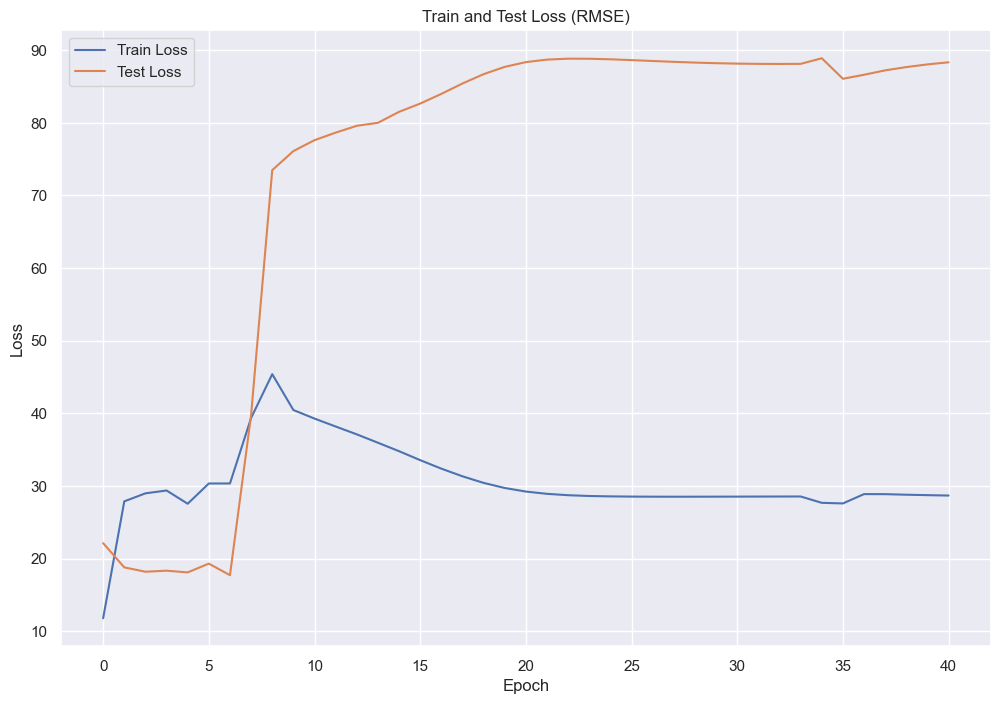

In [250]:
# plot train and test loss
train_hist = np.array(train_hist)
test_hist = np.array(test_hist)

train_rmse = np.sqrt(train_hist)
test_rmse = np.sqrt(test_hist)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_rmse, label="Train Loss")
ax.plot(test_rmse, label="Test Loss")
ax.set_title("Train and Test Loss (RMSE)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

In [ ]:
# Open-loop forecasting

num_forecast_steps = 30
sequence = 0 # which sequence to use for forecasting

test_sequence = sp500[:360, sequence] # test data
historical_data = test_sequence[:lookback_period]
forecasted_data = []

model.eval()
with torch.no_grad():
    historical_data_tensor = torch.from_numpy(historical_data).view(1, -1, 1).float().to(device)
    forecasted_data = model(historical_data_tensor).cpu().numpy()[0]


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test_sequence[:lookback_period], label="Historical Data")
ax.plot(np.arange(lookback_period, lookback_period + lookforward_period), test_sequence[lookback_period:lookback_period + lookforward_period], label="Actual Data")
ax.plot(np.arange(lookback_period, lookback_period + len(forecasted_data)), np.array(forecasted_data), label="Forecasted Data")
ax.set_title("Open-loop Forecasting (MinMaxScaler)")
ax.set_xlabel("Day")
ax.set_ylabel("Normalized Price")
ax.legend()